In [1]:
# The goal of this program is to determine the likelihood of Early Access Games to
# leave Early Access.

import pandas as pd
import pandas_profiling


def google_drive_useable(link):
    return link.replace('/open?', '/uc?')

data = r'https://drive.google.com/open?id=1pEOgqOZcgxwu7gA4GnFuMwO_wVBLQ7cf'
df   = pd.read_csv(google_drive_useable(data))

In [210]:
df.profile_report(style = {'full_width': True})

In [245]:
df['ReleaseType'].unique()

array(['Ex Early Access', 'Traditional Release', 'Early Access'],
      dtype=object)

In [2]:
# Split the data
from sklearn.model_selection import train_test_split

target      = 'ReleaseType'
filtered_df = df[df[target] != 'Traditional Release']

train, test = train_test_split(filtered_df
                              ,train_size   = 0.60
                              ,random_state = 6
                              )

train, val  = train_test_split(train
                              ,train_size   = 0.60
                              ,random_state = 6
                              )

In [3]:
# Baseline Guess is everything stays in Early Access

baseline_guess  = 'Early Access'
baseline_y_pred = [baseline_guess] * len(filtered_df)

filtered_df[target].value_counts(normalize = True)

Early Access       0.686798
Ex Early Access    0.313202
Name: ReleaseType, dtype: float64

In [5]:
len(train) + len(val) + len(test)

2136

In [4]:
target   = 'ReleaseType'
features = ['Metacritic'
           ,'ReleaseDate'
           
           ,'RecommendationCount'
           ,'DeveloperCount'
           ,'PublisherCount'
           ,'DLCCount'
           ,'ScreenshotCount'
           
           ,'CategorySinglePlayer'
           ,'CategoryMultiplayer'
           ,'CategoryCoop'
           ,'CategoryMMO'
           ,'CategoryInAppPurchase'
           ,'CategoryIncludeSrcSDK'
           ,'CategoryIncludeLevelEditor'
           ,'CategoryVRSupport'
           
           ,'GenreIsIndie'
           ,'GenreIsAction'
           ,'GenreIsAdventure'
           ,'GenreIsCasual'
           ,'GenreIsStrategy'
           ,'GenreIsRPG'
           ,'GenreIsSimulation'
           ,'GenreIsSports'
           ,'GenreIsRacing'
           ,'GenreIsMassivelyMultiplayer'
           
           ,'PlatformWindows'
           ,'PlatformLinux'
           ,'PlatformMac'
           
           ,'PriceInitial'
           ,'PriceFinal'
           ]

In [6]:
X_train  = train[features]
y_train  = train[target]

X_val    =  val[features]
y_val    =  val[target]

X_test   =  test[features]
y_test   =  test[target]

train.shape, test.shape

((768, 48), (855, 48))

In [7]:
import numpy             as np
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute   import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics  import accuracy_score, precision_score, recall_score


pipeline = make_pipeline(ce.OrdinalEncoder()
                        ,SimpleImputer()
                        ,RandomForestClassifier(n_estimators = 200)
                        )
pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_val_pred   = pipeline.predict(X_val)

y_train_prob = pipeline.predict_proba(X_train)[:,1]
y_val_prob   = pipeline.predict_proba(X_val)[:,1]

In [8]:
# A way to get my metrics all in one place.

def cat_prediction_results(y_train
                          ,y_val
                          ,y_train_pred
                          ,y_val_pred
                          ,cat_target    = y_train.unique()[0]
                          ,sort_by       = 'prediction'
                                                              ):
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score

    
    metrics     = {accuracy_score:  'Accuracy'
                  ,precision_score: 'Precision'
                  ,recall_score:    'Recall'
                  }
    
    base_y_pred = [cat_target] * len(y_train)
    
    predictions = [['Baseline',   y_train,  base_y_pred]
                  ,['Training',   y_train, y_train_pred]
                  ,['Validation', y_val,     y_val_pred]
                  ]
    
    if sort_by.lower() == 'prediction' or 'predictions':
        for prediction in predictions:
            for metric in metrics:
                if metrics[metric] == 'Accuracy':
                    print(prediction[0],  str(metrics[metric]) + ':\t', metric(prediction[1], prediction[2]))
                else:
                    print(prediction[0],  str(metrics[metric]) + ':\t', metric(prediction[1], prediction[2], pos_label = cat_target))
            print()
    else:
        for metric in metrics:
            if metrics[metric] == 'Accuracy':
                print("Baseline",   metrics[metric], ':\t', metric(y_train, baseline_y_pred))
                print("Training",   metrics[metric], ':\t', metric(y_train,    train_y_pred))
                print("Validation", metrics[metric], ':\t', metric(y_val,        val_y_pred))
            else:
                print("Baseline",   metrics[metric], ':\t', metric(y_train, baseline_y_pred, pos_label = cat_target))
                print("Training",   metrics[metric], ':\t', metric(y_train,    train_y_pred, pos_label = cat_target))
                print("Validation", metrics[metric], ':\t', metric(y_val,        val_y_pred, pos_label = cat_target))
            print()


In [9]:
search = cat_prediction_results(y_train
                               ,y_val
                               ,y_train_pred
                               ,y_val_pred
                               ,cat_target = 'Ex Early Access'
                               ,sort_by    = 'predictions'
                               )
search

Baseline Accuracy:	 0.3307291666666667
Baseline Precision:	 0.3307291666666667
Baseline Recall:	 1.0

Training Accuracy:	 1.0
Training Precision:	 1.0
Training Recall:	 1.0

Validation Accuracy:	 0.9239766081871345
Validation Precision:	 0.8940397350993378
Validation Recall:	 0.8544303797468354



## Visualizations

### Shap Plot
---

In [10]:
# An explainer which hooks into the model
from xgboost import XGBClassifier

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy = 'median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed   = processor.transform(X_val)

model     = XGBClassifier(n_estimators = 1000
                         ,n_jobs       = -1
                         )
model.fit(X_train_processed
         ,y_train
         ,eval_set              = [(X_val_processed, y_val)]
         ,eval_metric           = 'auc'
         ,early_stopping_rounds = 10
         ,verbose               = False
         )

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [11]:
def shap_explain(row):
    import shap
    
    explainer     = shap.TreeExplainer(model)
    
    selected_row  = X_train.iloc[[row]]
    row_processed = processor.transform(selected_row)
    
    shap.initjs()
    return shap.force_plot(base_value  = explainer.expected_value
                          ,shap_values = explainer.shap_values(row_processed)
                          ,features    = selected_row
                          ,link        = 'logit'
                          )

In [16]:
shap_explain(400)

## PDP Plot

---

In [19]:
pdp_pipe = make_pipeline(ce.OrdinalEncoder()
                        ,SimpleImputer()
                        ,RandomForestClassifier(n_estimators = 200
                                               ,n_jobs = -1
                                               ,random_state = 6
                                               )    
)

pdp_pipe.fit(X_train, y_train, verbose = False)

ValueError: Pipeline.fit does not accept the verbose parameter. You can pass parameters to specific steps of your pipeline using the stepname__parameter format, e.g. `Pipeline.fit(X, y, logisticregression__sample_weight=sample_weight)`.

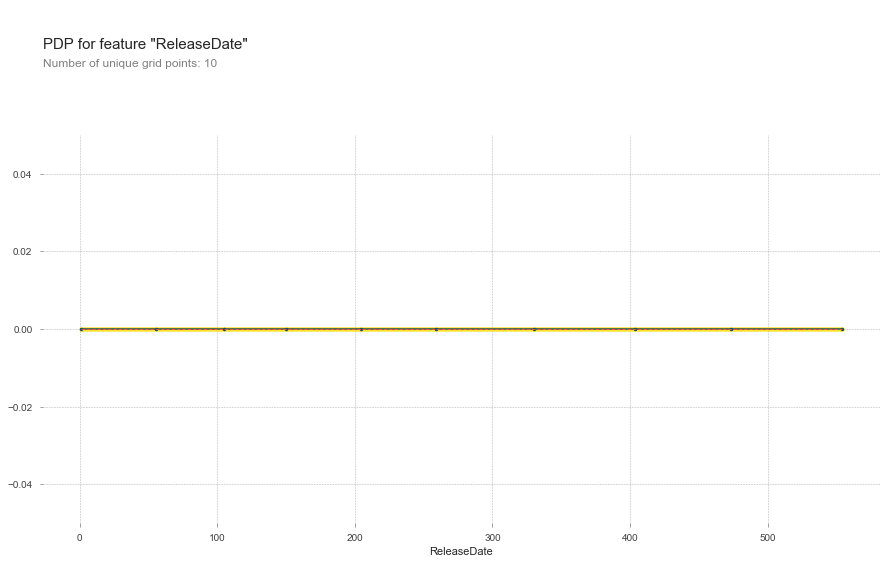

In [18]:
from pdpbox.pdp import pdp_isolate, pdp_plot

one_feature = 'ReleaseDate'

pdp_isolate = pdp_isolate(model          = new_pipe
                         ,dataset        = ce.OrdinalEncoder().fit_transform(X_train)
                         ,model_features = ce.OrdinalEncoder().fit_transform(X_train).columns
                         ,feature        = one_feature
                         )
pdp_plot(pdp_isolate
        ,feature_name = one_feature
        ,plot_lines   = True
        ,frac_to_plot = 100
        );